In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models,callbacks


# Loading MNIST DataSet

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Preprocessing the dataset

In [ ]:
# normalise the data  to 0-1
x_train = x_train / 255.0
x_test = x_test / 255.0

# flatten the data
x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)

# convert the output to categorical
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)


# Baseline Classifier Model

1. 5 Hidden layer with 1024 unit with batch normalization and dropout unit
2. Adam optimizer with 0.001 learning rate

In [ ]:
model = models.Sequential([
    layers.Input(shape=(784,)),

    layers.Dense(1024, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(1024, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(1024, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(1024, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(1024, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(10, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping once the model reaches validation accuracy of 98%

In [ ]:
early_stop = callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    mode='max',
    verbose=1,
    restore_best_weights=True
)

class TargetAccuracyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_accuracy') >= 0.98:
            print(f"\nReached 98% validation accuracy at epoch {epoch+1}, stopping training!")
            self.model.stop_training = True

In [ ]:
baseline_model = model
baseline_model.fit(
    x_train, y_train,
    epochs=500,
    batch_size=1024,
    validation_split=0.1,
    callbacks=[early_stop, TargetAccuracyCallback()],
    verbose=2)

Epoch 1/500
53/53 - 45s - 844ms/step - accuracy: 0.9037 - loss: 0.3354 - val_accuracy: 0.6630 - val_loss: 0.9410
Epoch 2/500
53/53 - 40s - 750ms/step - accuracy: 0.9690 - loss: 0.1013 - val_accuracy: 0.6510 - val_loss: 1.0329
Epoch 3/500
53/53 - 40s - 754ms/step - accuracy: 0.9781 - loss: 0.0668 - val_accuracy: 0.6602 - val_loss: 1.0001
Epoch 4/500
53/53 - 41s - 771ms/step - accuracy: 0.9831 - loss: 0.0506 - val_accuracy: 0.8048 - val_loss: 0.5243
Epoch 5/500
53/53 - 41s - 774ms/step - accuracy: 0.9859 - loss: 0.0414 - val_accuracy: 0.9438 - val_loss: 0.1890
Epoch 6/500
53/53 - 41s - 769ms/step - accuracy: 0.9895 - loss: 0.0323 - val_accuracy: 0.9622 - val_loss: 0.1427
Epoch 7/500
53/53 - 40s - 747ms/step - accuracy: 0.9900 - loss: 0.0294 - val_accuracy: 0.9668 - val_loss: 0.1229
Epoch 8/500

Reached 98% validation accuracy at epoch 8, stopping training!
53/53 - 40s - 757ms/step - accuracy: 0.9899 - loss: 0.0295 - val_accuracy: 0.9810 - val_loss: 0.0732
Restoring model weights from the

In [ ]:
baseline_model.save('baseline_model.h5')

# SVD Weights of different Singular values on various layers

$$ {W}^{(l)} = {U}^{(l)} {S}^{(l)} {{V}^{(l)}}^{⊤} $$

In [ ]:
# varying D singular value from 10, 20, 50....Dfull
D = [10, 20, 50, 100, 200,300,400,500,600,784]
test_accuracy = []
test_loss = []
# loop for calculating test accuracy for above D value compression
for j in D:
  Base_model = tf.keras.models.load_model('baseline_model.h5')
  dense_layers = [layer for layer in Base_model.layers if isinstance(layer, tf.keras.layers.Dense)]
  for i, layer in enumerate(dense_layers[:-1]):
    W, b = layer.get_weights()
    print(f"\nRunning SVD on layer {i+1} with the shape {W.shape}")
    s, u, v = tf.linalg.svd(W)
    k = j
    print(f"{k} singular values")
    Uk = u[:, :k]
    Sk = tf.linalg.diag(s[:k])
    Vk = v[:, :k]
    W_approx = tf.matmul(Uk, tf.matmul(Sk, tf.transpose(Vk)))
    layer.set_weights([W_approx.numpy(), b])
    print("\n SVD applied to all hidden Dense layers")

  test_loss, test_acc = Base_model.evaluate(x_test, y_test, verbose=0)
  test_accuracy.append(test_acc)
  print(f"Test Accuracy after compression: {test_acc * 100:.2f}%")


Running SVD on layer 1 with the shape (784, 1024)
10 singular values

 SVD applied to all hidden Dense layers

Running SVD on layer 2 with the shape (1024, 1024)
10 singular values

 SVD applied to all hidden Dense layers

Running SVD on layer 3 with the shape (1024, 1024)
10 singular values

 SVD applied to all hidden Dense layers

Running SVD on layer 4 with the shape (1024, 1024)
10 singular values

 SVD applied to all hidden Dense layers

Running SVD on layer 5 with the shape (1024, 1024)
10 singular values

 SVD applied to all hidden Dense layers
Test Accuracy after compression: 55.01%



Running SVD on layer 1 with the shape (784, 1024)
20 singular values

 SVD applied to all hidden Dense layers

Running SVD on layer 2 with the shape (1024, 1024)
20 singular values

 SVD applied to all hidden Dense layers

Running SVD on layer 3 with the shape (1024, 1024)
20 singular values

 SVD applied to all hidden Dense layers

Running SVD on layer 4 with the shape (1024, 1024)
20 singular values

 SVD applied to all hidden Dense layers

Running SVD on layer 5 with the shape (1024, 1024)
20 singular values

 SVD applied to all hidden Dense layers
Test Accuracy after compression: 80.29%



Running SVD on layer 1 with the shape (784, 1024)
50 singular values

 SVD applied to all hidden Dense layers

Running SVD on layer 2 with the shape (1024, 1024)
50 singular values

 SVD applied to all hidden Dense layers

Running SVD on layer 3 with the shape (1024, 1024)
50 singular values

 SVD applied to all hidden Dense layers

Running SVD on layer 4 with the shape (1024, 1024)
50 singular values

 SVD applied to all hidden Dense layers

Running SVD on layer 5 with the shape (1024, 1024)
50 singular values

 SVD applied to all hidden Dense layers
Test Accuracy after compression: 87.81%



Running SVD on layer 1 with the shape (784, 1024)
100 singular values

 SVD applied to all hidden Dense layers

Running SVD on layer 2 with the shape (1024, 1024)
100 singular values

 SVD applied to all hidden Dense layers

Running SVD on layer 3 with the shape (1024, 1024)
100 singular values

 SVD applied to all hidden Dense layers

Running SVD on layer 4 with the shape (1024, 1024)
100 singular values

 SVD applied to all hidden Dense layers

Running SVD on layer 5 with the shape (1024, 1024)
100 singular values

 SVD applied to all hidden Dense layers
Test Accuracy after compression: 93.42%



Running SVD on layer 1 with the shape (784, 1024)
200 singular values

 SVD applied to all hidden Dense layers

Running SVD on layer 2 with the shape (1024, 1024)
200 singular values

 SVD applied to all hidden Dense layers

Running SVD on layer 3 with the shape (1024, 1024)
200 singular values

 SVD applied to all hidden Dense layers

Running SVD on layer 4 with the shape (1024, 1024)
200 singular values

 SVD applied to all hidden Dense layers

Running SVD on layer 5 with the shape (1024, 1024)
200 singular values

 SVD applied to all hidden Dense layers
Test Accuracy after compression: 96.70%



Running SVD on layer 1 with the shape (784, 1024)
300 singular values

 SVD applied to all hidden Dense layers

Running SVD on layer 2 with the shape (1024, 1024)
300 singular values

 SVD applied to all hidden Dense layers

Running SVD on layer 3 with the shape (1024, 1024)
300 singular values

 SVD applied to all hidden Dense layers

Running SVD on layer 4 with the shape (1024, 1024)
300 singular values

 SVD applied to all hidden Dense layers

Running SVD on layer 5 with the shape (1024, 1024)
300 singular values

 SVD applied to all hidden Dense layers
Test Accuracy after compression: 97.37%



Running SVD on layer 1 with the shape (784, 1024)
400 singular values

 SVD applied to all hidden Dense layers

Running SVD on layer 2 with the shape (1024, 1024)
400 singular values

 SVD applied to all hidden Dense layers

Running SVD on layer 3 with the shape (1024, 1024)
400 singular values

 SVD applied to all hidden Dense layers

Running SVD on layer 4 with the shape (1024, 1024)
400 singular values

 SVD applied to all hidden Dense layers

Running SVD on layer 5 with the shape (1024, 1024)
400 singular values

 SVD applied to all hidden Dense layers
Test Accuracy after compression: 97.63%



Running SVD on layer 1 with the shape (784, 1024)
500 singular values

 SVD applied to all hidden Dense layers

Running SVD on layer 2 with the shape (1024, 1024)
500 singular values

 SVD applied to all hidden Dense layers

Running SVD on layer 3 with the shape (1024, 1024)
500 singular values

 SVD applied to all hidden Dense layers

Running SVD on layer 4 with the shape (1024, 1024)
500 singular values

 SVD applied to all hidden Dense layers

Running SVD on layer 5 with the shape (1024, 1024)
500 singular values

 SVD applied to all hidden Dense layers
Test Accuracy after compression: 97.78%



Running SVD on layer 1 with the shape (784, 1024)
600 singular values

 SVD applied to all hidden Dense layers

Running SVD on layer 2 with the shape (1024, 1024)
600 singular values

 SVD applied to all hidden Dense layers

Running SVD on layer 3 with the shape (1024, 1024)
600 singular values

 SVD applied to all hidden Dense layers

Running SVD on layer 4 with the shape (1024, 1024)
600 singular values

 SVD applied to all hidden Dense layers

Running SVD on layer 5 with the shape (1024, 1024)
600 singular values

 SVD applied to all hidden Dense layers
Test Accuracy after compression: 97.87%



Running SVD on layer 1 with the shape (784, 1024)
784 singular values

 SVD applied to all hidden Dense layers

Running SVD on layer 2 with the shape (1024, 1024)
784 singular values

 SVD applied to all hidden Dense layers

Running SVD on layer 3 with the shape (1024, 1024)
784 singular values

 SVD applied to all hidden Dense layers

Running SVD on layer 4 with the shape (1024, 1024)
784 singular values

 SVD applied to all hidden Dense layers

Running SVD on layer 5 with the shape (1024, 1024)
784 singular values

 SVD applied to all hidden Dense layers
Test Accuracy after compression: 97.95%


#  test accuracies of the SVDed versions

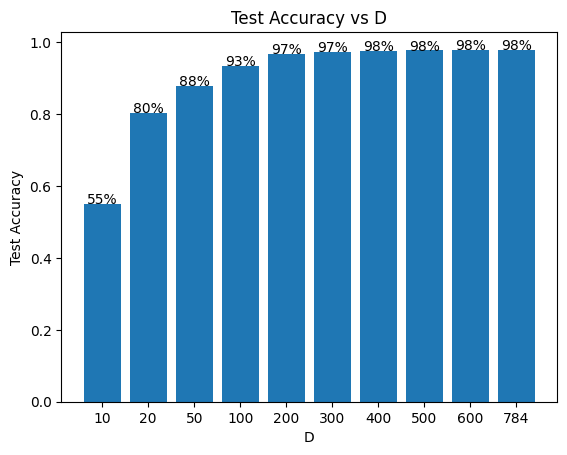

In [ ]:
import matplotlib.pyplot as plt

D_str =  list(map(str, D))
plt.bar(D_str,test_accuracy)

for xi, yi in zip(D_str, test_accuracy):
    plt.text(xi, yi , f"{yi*100:.0f}" + '%', ha='center')
plt.xlabel('D')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs D')
plt.show()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

from google.colab import files

!jupyter nbconvert --to html "/content/drive/MyDrive/Colab Notebooks/DLS_HW_3_1.ipynb"
files.download("/content/drive/MyDrive/Colab Notebooks/DLS_HW_3_1.html")

Mounted at /content/drive
[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/DLS_HW_3_1.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 1 image(s).
[NbConvertApp] Writing 339828 bytes to /content/drive/MyDrive/Colab Notebooks/DLS_HW_3_1.html


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>